In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.pyplot as plt
import sklearn.metrics as sklm
from sklearn.linear_model import Ridge, LinearRegression
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [12, 8]
newl = '\n'

def split_list(list, window_len, stride=None):
    stride = window_len if stride is None else stride
    return [list[i:i+window_len] for i in range(0, len(list), stride) if len(list[i:i+window_len]) == window_len]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
def p1(df, sz, key):
    #******     part 1

    print(f'Part 1:{newl}1. Differentiate different window sizes with respect to the autocorrelation.{newl}')

    dfWin = split_list(df, sz)
    B = np.array([dfWin[k][key].values for k in range(len(dfWin))])
    autocorrelation_plot(B)

    return

def p2(df, windowSz, key):
    #******     part 2

    print(f'Part 2:{newl}1. Construct A and B{newl}2. Determine X to minimize ||AX-B||**2{newl}3. Evaluate our determination with a regressive error metric.{newl}')

    if (windowSz < 1):
        windowSz = 1

    dfWin = split_list(df, windowSz)

    _A_train = np.array([dfWin[k][key].values[:-1] for k in range(0, len(dfWin), 2)])
    _A_test = np.array([dfWin[k][key].values[:-1] for k in range(1, len(dfWin), 2)])

    A_train = np.insert(_A_train, 0, np.ones(len(_A_train), dtype='float'), axis=1)
    A_test = np.insert(_A_test, 0, np.ones(len(_A_test), dtype='float'), axis=1)

    B_train = np.array([dfWin[k][key].values[-1] for k in range(0, len(dfWin), 2)])
    B_test = np.array([dfWin[k][key].values[-1] for k in range(1, len(dfWin), 2)])

    lreg = LinearRegression().fit(A_train, B_train)
    B_pred = lreg.predict(A_test)

    rmse = (sklm.mean_squared_error(B_test, B_pred)**(1/2))
    r2 = sklm.r2_score(B_test, B_pred)

    #rmse output
    print(f'The window size is {windowSz}.{newl}RMSE = {rmse}.{newl}R2 score = {r2}.{newl}')

    return lreg.coef_

def p3(df, windowSz, key, delta=1):
    #**********     part 3

    print(f'Part 3:{newl}1. Determine X by Ridge regularization.{newl}2. Evaluate X by the regressive error metric from Part 2.{newl}')

    if (windowSz < 1):
        windowSz = 1

    dfWin = split_list(df, windowSz)

    _A_training = np.array([dfWin[k][key].values[:-1] for k in range(0, len(dfWin), 2)])
    _A_test = np.array([dfWin[k][key].values[:-1] for k in range(1, len(dfWin), 2)])

    A_training = np.insert(_A_training, 0, np.ones(len(_A_training), dtype='float'), axis=1)
    A_test = np.insert(_A_test, 0, np.ones(len(_A_test), dtype='float'), axis=1)

    B_training = np.array([dfWin[k][key].values[-1] for k in range(0, len(dfWin), 2)])
    B_test = np.array([dfWin[k][key].values[-1] for k in range(1, len(dfWin), 2)])

    rf = Ridge(alpha=delta)
    rf.fit(A_training, B_training)
    B_pred = rf.predict(A_test)

    rmse = sklm.mean_squared_error(B_test, B_pred)**(1/2)
    r2 = sklm.r2_score(B_test, B_pred)
   
    print(f'The window size is {windowSz}.{newl}The RMSE for Ridge(alpha={delta}) is {rmse}.')
    print(f'The R2 score for Ridge(alpha={delta}) is {r2}.{newl}')

    return rf.coef_

def p4(df, windowSz, key):
    #**********     part 4

    print(f'Part 4:{newl}1. Determine X by Weighted LSR.{newl}2. Evaluate X by the regressive error metric from Part 2.{newl}')

    if (windowSz < 1):
        windowSz = 2
    if (windowSz % 2 != 0):
        windowSz += 1

    dfWin = split_list(df, windowSz)

    _A_training = np.array([dfWin[k][key].values[:-1] for k in range(0, len(dfWin), 2)])
    _A_test = np.array([dfWin[k][key].values[:-1] for k in range(1, len(dfWin), 2)])

    A_training = np.insert(_A_training, 0, np.ones(len(_A_training), dtype='float'), axis=1)
    A_test = np.insert(_A_test, 0, np.ones(len(_A_test), dtype='float'), axis=1)

    B_training = np.array([dfWin[k][key].values[-1] for k in range(0, len(dfWin), 2)])
    B_test = np.array([dfWin[k][key].values[-1] for k in range(1, len(dfWin), 2)])

    lreg = LinearRegression().fit(A_training, B_training)
    B_pred = lreg.predict(A_test)

    error = np.array([(B_pred[k]-B_test[k])**2 for k in range(len(B_test))])
    weights = 1 / error

    wlreg = sm.WLS(B_test, A_test, weights)
    result = wlreg.fit()
    x = np.array(result.params)

    B_pred = np.array([np.sum(A_training[k]*x) for k in range(len(A_training))])

    rmse = sklm.mean_squared_error(B_training, B_pred)**(1/2)
    r2 = sklm.r2_score(B_training, B_pred)
   
    print(f'The window size is {windowSz}.{newl}The RMSE for Weighted LSR is {rmse}.')
    print(f'The R2 score for Weighted LSR is {r2}.')

    return result.params

def p5(df, sz, key, corr1, corr2, corr3):
    #part 5
    print(f"Part 5:{newl}")

    dfWin = split_list(df, sz)
    B = np.array([dfWin[k][key].values[-1] for k in range(len(dfWin))])
    _A = np.array([dfWin[k][key].values[:-1] for k in range(len(dfWin))])
    A = np.insert(_A, 0, np.ones(len(_A)), axis=1) 

    fig, axes = plt.subplots(1, 4, dpi=100)
    autocorrelation_plot(B, ax=axes[0], color='k')
    autocorrelation_plot(np.array([np.sum(A[k]*corr1) for k in range(len(A))]), ax=axes[1], color='red')
    autocorrelation_plot(np.array([np.sum(A[k]*corr2) for k in range(len(A))]), ax=axes[2], color='green')
    autocorrelation_plot(np.array([np.sum(A[k]*corr3) for k in range(len(A))]), ax=axes[3], color='blue')

    return 

def p6(df, key):

    return

***************************
   File 2   
***************************

Part 1:
1. Differentiate different window sizes with respect to the autocorrelation.

Part 2:
1. Construct A and B
2. Determine X to minimize ||AX-B||**2
3. Evaluate our determination with a regressive error metric.

The window size is 2000.
RMSE = 2.9635673437555585.
R2 score = 0.7029228005216621.

Part 3:
1. Determine X by Ridge regularization.
2. Evaluate X by the regressive error metric from Part 2.

The window size is 2000.
The RMSE for Ridge(alpha=0.03) is 2.9650327677955155.
The R2 score for Ridge(alpha=0.03) is 0.7026289305644502.

Part 4:
1. Determine X by Weighted LSR.
2. Evaluate X by the regressive error metric from Part 2.

The window size is 2000.
The RMSE for Weighted LSR is 2.7416994749801544.
The R2 score for Weighted LSR is 0.62586379405241.
Part 5:



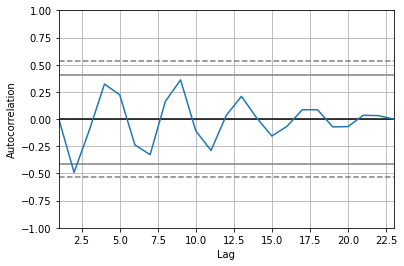

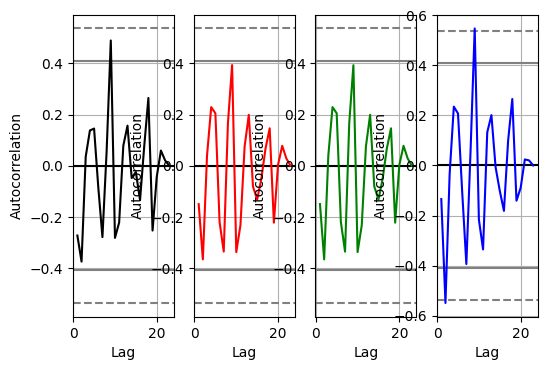

In [10]:
#fname = './../data/data_filled/FILLED_log_2021_02_27-07_34_43_BB.csv'
#df = pd.read_csv(fname)

#print(f'***************************{newl}   File 1   {newl}***************************{newl}')

#p1(df, 'BtoB')
#p2(df, 1000, 'BtoB')
#p3(df, 1000, 'BtoB', 0.03)
#p4(df, 1000, 'BtoB')

fname2 = '/content/sample_data/dublin_weather.csv'
#df2 = pd.read_csv(fname2, dtype={'rain':float, 'temp':float}, parse_dates=['date'])
df2 = pd.read_csv(fname2, parse_dates=['date'], index_col=2)
df2 = df2.loc[(df2['date'] > pd.to_datetime('2014-12-31 23:59:59'))]
df2.drop(columns=['county'], inplace=True)
df2.reset_index(inplace=True)

print(f'***************************{newl}   File 2   {newl}***************************{newl}')

sz = 2000
p1(df2, sz, 'temp')
lreg_coef = p2(df2, sz, 'temp')
ridge_coef = p3(df2, sz, 'temp', 0.03)
wlreg_coef = p4(df2, sz, 'temp')
p5(df2, sz, 'temp', lreg_coef, ridge_coef, wlreg_coef)

plt.show()